## **Capstone MDS - RNN**

#### **_Integrantes:_**  

1. Evans Díaz   
1. Felipe Ojeda
1. Javier Cofre  
1. Luis Reinoso

In [1]:
# importar librerías
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import EngFormatter

/Users/ediazl/Documents/py_venv/venv-metal/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# función creación matrix X & y según "lag" dado
def Matrix_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
    
  return np.array(X), np.array(y)

In [3]:
# función cálculo R2, RMSE y MSE
def R2_RMSE(y_true, y_pred, std_y, mean_y):
  # los devuelvo a sus valores originales antes de la estandarización 
  y_true = y_true * std_y + mean_y
  y_pred = y_pred * std_y + mean_y

  # cálculo de R2 y RMSE
  r2 = r2_score(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  
  return print('R2:',r2), print('RMSE:',rmse), print('MSE:', mse)

## **_1. Lectura (carga) de los Datos_**

In [4]:
# importamos archivo
df = pd.read_csv('../Data/df_final_pay_sin_mt.csv')

In [5]:
# miramos el dataframe
df.head()

,year_2023,year_2024,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,CAT 798-AC,KOM-CHQ,KOM.960E5,Kom.930E-4,Kom.930E-4SE,Kom.930EN,Kom.930ER,Kom.930ER-MT,Kom.980E5,Komatsu AHS
0,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0
1,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,396.0,96.0,240.0,0.0,132.0,24.0
2,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,394.0,96.0,240.0,0.0,132.0,24.0
3,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,95.0,396.0,96.0,240.0,0.0,132.0,24.0
4,False,False,False,False,False,False,False,False,False,False,...,0.0,0.0,24.0,96.0,395.0,96.0,240.0,0.0,132.0,24.0


In [6]:
# información general df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 84 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_2023            1567 non-null   bool   
 1   year_2024            1567 non-null   bool   
 2   month_2              1567 non-null   bool   
 3   month_3              1567 non-null   bool   
 4   month_4              1567 non-null   bool   
 5   month_5              1567 non-null   bool   
 6   month_6              1567 non-null   bool   
 7   month_7              1567 non-null   bool   
 8   month_8              1567 non-null   bool   
 9   month_9              1567 non-null   bool   
 10  month_10             1567 non-null   bool   
 11  month_11             1567 non-null   bool   
 12  month_12             1567 non-null   bool   
 13  day_2                1567 non-null   bool   
 14  day_3                1567 non-null   bool   
 15  day_4                1567 non-null   b

## **_2 Preparación del DataFrame_**

### _2.1. Definición Variables Categóricas_

In [7]:
# transformamos las variables bool a categorical y le asignamos 0 o 1
for col in df.columns:
  if df[col].dtype == 'bool':
     df[col] = df[col].astype('category').cat.codes
     df[col] = df[col].astype('category') # para que quede como category y no como int8

In [8]:
print('Nombre Columnas: ',df.columns)
print('Cantidad Columnas: ',len(df.columns))

Nombre Columnas:  Index(['year_2023', 'year_2024', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7',
       'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14',
       'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21',
       'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28',
       'day_29', 'day_30', 'day_31', 'shift_B', 'crew_E2', 'crew_E3',
       'crew_E4', 'total', 'efectivo', 'mantencion', 'mecanica', 'electrica',
       'mant_excl', 'mec_excl', 'elec_excl', 'som_excl', 'demora', 'r_prog',
       'r_noprg', 'waiting', 'queued', 'payload', 'distance', 'distance_down',
       'distance_down_level', 'distance_up', 'distance_up_level',
       'expected_time', 'lift_down', 'lift_down_level', 'lift_up',
       'lift_up_level', 'travel_time', 'CAT 797-F', 'CAT 798-AC', 'KOM-CHQ',
       'KOM.96

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Data columns (total 84 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   year_2023            1567 non-null   category
 1   year_2024            1567 non-null   category
 2   month_2              1567 non-null   category
 3   month_3              1567 non-null   category
 4   month_4              1567 non-null   category
 5   month_5              1567 non-null   category
 6   month_6              1567 non-null   category
 7   month_7              1567 non-null   category
 8   month_8              1567 non-null   category
 9   month_9              1567 non-null   category
 10  month_10             1567 non-null   category
 11  month_11             1567 non-null   category
 12  month_12             1567 non-null   category
 13  day_2                1567 non-null   category
 14  day_3                1567 non-null   category
 15  day_4                

In [10]:
# cálculamos la desviaicón estándar y la media de payload
std_y = df['payload'].std()
mean_y = df['payload'].mean()

print('Desviación Estándar:',std_y)
print('Media:',mean_y)

Desviación Estándar: 19936.05577427206
Media: 142357.4639507874


### _2.2 Estandarización de Variables Numéricas_

In [11]:
# estandarizamos las variables numéricas
col_num = df.select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
df[col_num] = scaler.fit_transform(df[col_num])

In [12]:
df[col_num]

,total,efectivo,mantencion,mecanica,electrica,mant_excl,mec_excl,elec_excl,som_excl,demora,...,CAT 798-AC,KOM-CHQ,KOM.960E5,Kom.930E-4,Kom.930E-4SE,Kom.930EN,Kom.930ER,Kom.930ER-MT,Kom.980E5,Komatsu AHS
0,-2.655292,-0.004485,-0.285657,-1.862441,-0.721030,0.070456,-0.494502,-0.383416,-0.542790,1.501190,...,-0.213340,-0.575556,2.735792,0.191462,0.563663,2.277691,0.101727,-0.035749,-2.981670,-0.101592
1,-2.609231,-0.150119,0.267412,-2.068534,-0.302548,-0.275540,-0.163688,-0.657358,0.012994,0.821500,...,-0.213340,-0.575556,2.735792,0.191462,0.607062,2.277691,0.101727,-0.035749,-2.981670,-0.101592
2,-2.701353,-0.870796,0.905168,-2.187625,-0.983502,-0.397226,-0.144525,1.613826,0.215479,1.554988,...,-0.213340,-0.575556,2.735792,0.191462,0.520264,2.277691,0.101727,-0.035749,-2.981670,-0.101592
3,-2.655292,-0.384935,0.595569,-2.238718,0.221161,-0.751238,-0.351754,0.305468,0.260929,0.023847,...,-0.213340,-0.575556,2.735792,-1.756724,0.607062,2.277691,0.101727,-0.035749,-2.981670,-0.101592
4,-2.655292,-0.347492,0.595011,-2.393621,-0.962720,0.281214,-0.373091,0.436407,0.515131,0.860647,...,-0.213340,-0.575556,2.735792,0.191462,0.563663,2.277691,0.101727,-0.035749,-2.981670,-0.101592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,0.661092,0.902508,0.325973,0.473747,-0.303865,-1.240633,-0.995820,-0.657358,-0.375358,-0.318173,...,4.999982,-0.575556,-0.505479,0.191462,1.127852,-0.485337,0.101727,-0.035749,0.345965,-1.147779
1563,-0.444369,0.652524,-0.412607,0.489265,0.106798,-0.174357,-0.796527,2.080902,-0.906260,0.727924,...,4.999982,-0.575556,-0.505479,0.191462,1.084453,-1.176095,-9.913288,-0.035749,0.345965,-1.147779
1564,-0.398308,0.981398,0.380470,0.218474,0.274866,0.098628,-0.863005,0.359177,-0.988625,-0.554423,...,4.999982,-0.575556,-0.505479,0.191462,1.127852,-1.176095,-9.913288,-0.035749,0.345965,-1.147779
1565,-0.444369,0.731425,0.957582,0.423084,-0.356006,0.243151,-0.637886,0.065837,-1.484020,0.099858,...,4.999982,-0.575556,-0.505479,0.191462,1.127852,-1.176095,-9.913288,-0.035749,0.345965,-1.147779


In [13]:
# dejo la variable objetivo en la primera columna
columnas_sin_target = df.drop(['payload'], axis=1).columns.tolist()
df = df[['payload'] + columnas_sin_target]
df

,payload,year_2023,year_2024,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,CAT 798-AC,KOM-CHQ,KOM.960E5,Kom.930E-4,Kom.930E-4SE,Kom.930EN,Kom.930ER,Kom.930ER-MT,Kom.980E5,Komatsu AHS
0,2.694037,0,0,0,0,0,0,0,0,0,...,-0.213340,-0.575556,2.735792,0.191462,0.563663,2.277691,0.101727,-0.035749,-2.981670,-0.101592
1,2.411105,0,0,0,0,0,0,0,0,0,...,-0.213340,-0.575556,2.735792,0.191462,0.607062,2.277691,0.101727,-0.035749,-2.981670,-0.101592
2,2.034113,0,0,0,0,0,0,0,0,0,...,-0.213340,-0.575556,2.735792,0.191462,0.520264,2.277691,0.101727,-0.035749,-2.981670,-0.101592
3,1.779473,0,0,0,0,0,0,0,0,0,...,-0.213340,-0.575556,2.735792,-1.756724,0.607062,2.277691,0.101727,-0.035749,-2.981670,-0.101592
4,2.115702,0,0,0,0,0,0,0,0,0,...,-0.213340,-0.575556,2.735792,0.191462,0.563663,2.277691,0.101727,-0.035749,-2.981670,-0.101592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,-1.117204,0,1,1,0,0,0,0,0,0,...,4.999982,-0.575556,-0.505479,0.191462,1.127852,-0.485337,0.101727,-0.035749,0.345965,-1.147779
1563,-1.339841,0,1,1,0,0,0,0,0,0,...,4.999982,-0.575556,-0.505479,0.191462,1.084453,-1.176095,-9.913288,-0.035749,0.345965,-1.147779
1564,-1.618469,0,1,1,0,0,0,0,0,0,...,4.999982,-0.575556,-0.505479,0.191462,1.127852,-1.176095,-9.913288,-0.035749,0.345965,-1.147779
1565,-0.629214,0,1,1,0,0,0,0,0,0,...,4.999982,-0.575556,-0.505479,0.191462,1.127852,-1.176095,-9.913288,-0.035749,0.345965,-1.147779


### _2.3 Selección de Variables - Lasso_

In [14]:
df_filtrado = df.copy()

### _2.4 Generación de Matrices X & y para RNN_

In [15]:
# definimos la ventana del lag (L)
window_size = 14
# llamamos a la función para crear la matriz X & y
X, y = Matrix_X_y(df_filtrado, window_size)
X.shape, y.shape

((1553, 14, 84), (1553,))

In [16]:
# miramos X
X

array([[[ 2.69403692,  0.        ,  0.        , ..., -0.0357485 ,
         -2.98167027, -0.10159203],
        [ 2.41110496,  0.        ,  0.        , ..., -0.0357485 ,
         -2.98167027, -0.10159203],
        [ 2.03411307,  0.        ,  0.        , ..., -0.0357485 ,
         -2.98167027, -0.10159203],
        ...,
        [-1.02253639,  0.        ,  0.        , ..., -0.0357485 ,
         -2.98167027, -0.10159203],
        [-0.38957016,  0.        ,  0.        , ..., -0.0357485 ,
         -2.98167027, -0.10159203],
        [ 1.85193434,  0.        ,  0.        , ..., -0.0357485 ,
         -2.98167027, -0.10159203]],

       [[ 2.41110496,  0.        ,  0.        , ..., -0.0357485 ,
         -2.98167027, -0.10159203],
        [ 2.03411307,  0.        ,  0.        , ..., -0.0357485 ,
         -2.98167027, -0.10159203],
        [ 1.77947333,  0.        ,  0.        , ..., -0.0357485 ,
         -2.98167027, -0.10159203],
        ...,
        [-0.38957016,  0.        ,  0.        , ..., -

In [17]:
# miramos y
y

array([ 1.73289519,  2.10807827,  1.76741861, ..., -1.61846894,
       -0.62921389, -0.67916419])

In [18]:
X_train, y_train = X[:1200], y[:1200]
X_val, y_val = X[1200:1350], y[1200:1350]
X_test, y_test = X[1350:], y[1350:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1200, 14, 84), (1200,), (150, 14, 84), (150,), (203, 14, 84), (203,))

## **_3 RNN_**

In [19]:
# librerias para RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### _3.1 Simple RNN_

In [20]:
# generalización del modelo
model1 = Sequential()
model1.add(InputLayer(input_shape=(window_size, X.shape[2])))  
model1.add(SimpleRNN(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model1.add(SimpleRNN(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model1.add(SimpleRNN(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model1.add(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(1, activation='linear'))  

# introducimos callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model1.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])  
history1 = model1.fit(X_train, y_train,
                    epochs=50,
                    batch_size=96,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

/Users/ediazl/Documents/py_venv/venv-metal/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-06-22 19:51:48.177885: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Ultra
2024-06-22 19:51:48.177912: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-06-22 19:51:48.177918: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-06-22 19:51:48.177980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-22 19:51:48.178003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci

Epoch 1/50


2024-06-22 19:51:49.434713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 547ms/step - loss: 1.6932 - mae: 1.0320 - val_loss: 0.8101 - val_mae: 0.7151 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 484ms/step - loss: 0.8268 - mae: 0.7215 - val_loss: 0.4257 - val_mae: 0.5093 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 401ms/step - loss: 0.7556 - mae: 0.6840 - val_loss: 0.3604 - val_mae: 0.4829 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step - loss: 0.6835 - mae: 0.6566 - val_loss: 0.3670 - val_mae: 0.4861 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - loss: 0.6089 - mae: 0.6155 - val_loss: 0.4281 - val_mae: 0.5302 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - loss: 0.5932 - mae: 0.6123 - val_loss: 0.4225 - val_mae: 0.5281 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step - loss: 0.6142 - mae: 0.6153 - val_loss: 0.3886 - val_mae: 0.5056 - learning_rate: 0.0010
Epoch 8/50
13/13

In [21]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 14, 128)        │        27,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 14, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 14, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,581 (658.52 KB)

 Trainable params: 56,193 (219.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 112,388 (439.02 KB)

In [22]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


,Train Predictions,Actuals
0,1.304151,1.732895
1,1.476253,2.108078
2,1.390018,1.767419
3,1.530795,1.866855
4,1.344810,1.910518
...,...,...
1195,-0.454383,-1.073597
1196,-0.452123,-1.011739
1197,-0.455201,-0.958293
1198,-0.501502,-1.037339


In [23]:
# resultados train R2, RMSE y MSE
R2_RMSE(train_results['Actuals'], train_results['Train Predictions'], std_y, mean_y)

R2: 0.4793619897815621
RMSE: 14109.358323424027
MSE: 199073992.29877487


(None, None, None)

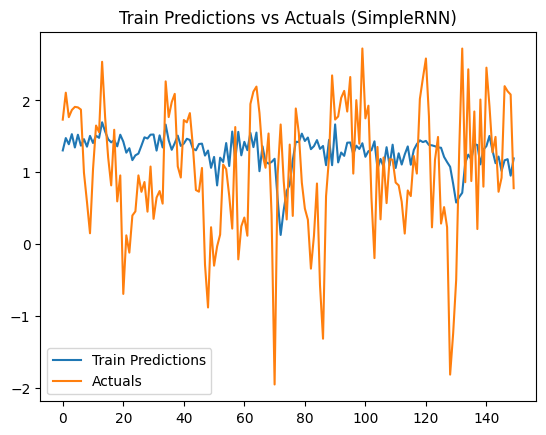

In [24]:
plt.plot(train_results['Train Predictions'][:150])
plt.plot(train_results['Actuals'][:150])

plt.title('Train Predictions vs Actuals (SimpleRNN)')
plt.legend(['Train Predictions', 'Actuals'])
plt.show()

In [25]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


,Test Predictions,Actuals
0,-0.425776,-0.630026
1,-0.361315,-0.558260
2,-0.519210,0.665232
3,-0.454083,0.240866
4,-0.698458,-0.637923
...,...,...
198,-0.216714,-1.117204
199,-0.223689,-1.339841
200,-0.541268,-1.618469
201,-0.517217,-0.629214


In [26]:
# resultados test R2, RMSE y MSE
R2_RMSE(test_results['Actuals'], test_results['Test Predictions'], std_y, mean_y)

R2: -0.47292135399559343
RMSE: 14885.863916776321
MSE: 221588944.5487833


(None, None, None)

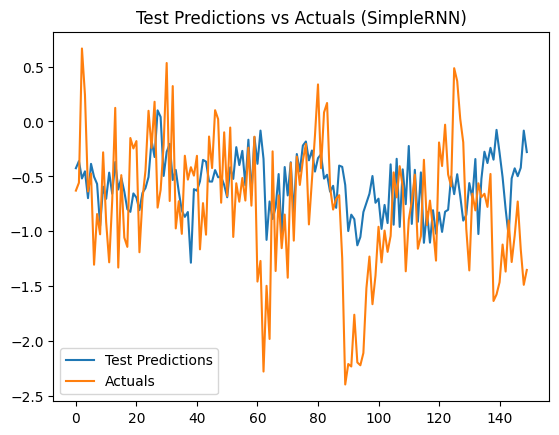

In [27]:
plt.plot(test_results['Test Predictions'][:150])
plt.plot(test_results['Actuals'][:150])

plt.title('Test Predictions vs Actuals (SimpleRNN)')
plt.legend(['Test Predictions', 'Actuals'])
plt.show()

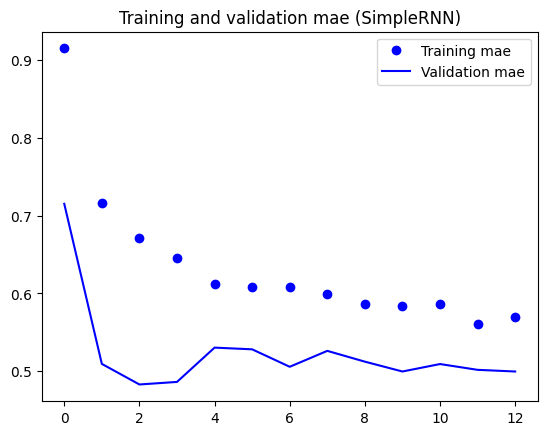

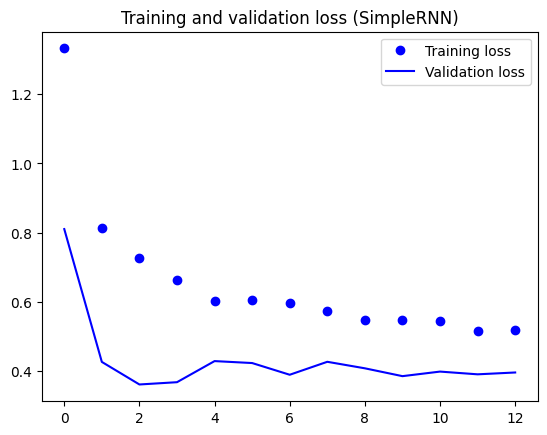

In [28]:
mae = history1.history['mae']
val_mae = history1.history['val_mae']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae (SimpleRNN)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (SimpleRNN)')
plt.legend()

plt.show()

### _3.2 LSTM_

In [29]:
# generalización del modelo
model2 = Sequential()
model2.add(LSTM(128, input_shape=(window_size, X.shape[2]), return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
model2.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='linear'))  

# introducimos callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model2.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])  
history2 = model2.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50


/Users/ediazl/Documents/py_venv/venv-metal/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 504ms/step - loss: 0.6168 - mae: 0.6203 - val_loss: 0.4179 - val_mae: 0.5126 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - loss: 0.5037 - mae: 0.5599 - val_loss: 0.4713 - val_mae: 0.5391 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 490ms/step - loss: 0.4895 - mae: 0.5467 - val_loss: 0.4563 - val_mae: 0.5478 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 505ms/step - loss: 0.4795 - mae: 0.5402 - val_loss: 0.5028 - val_mae: 0.5711 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - loss: 0.4262 - mae: 0.5190 - val_loss: 0.4773 - val_mae: 0.5537 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - loss: 0.3958 - mae: 0.4958 - val_loss: 0.4697 - val_mae: 0.5554 - learning_rate: 0.0010
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 509ms/step - loss: 0.4081 - mae: 0.4921 - val_loss: 0.4381 - val_mae: 0.5208 - learning_rate: 0.0010
Epoch 8/50

In [30]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 128)        │       109,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 14, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,661 (2.19 MB)

 Trainable params: 191,553 (748.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 383,108 (1.46 MB)

In [31]:
train_predictions = model2.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


,Train Predictions,Actuals
0,1.624270,1.732895
1,1.769142,2.108078
2,1.867102,1.767419
3,1.911068,1.866855
4,1.817247,1.910518
...,...,...
1195,-1.155372,-1.073597
1196,-1.246794,-1.011739
1197,-1.300085,-0.958293
1198,-1.262033,-1.037339


In [32]:
# resultados train R2, RMSE y MSE
R2_RMSE(train_results['Actuals'], train_results['Train Predictions'], std_y, mean_y)

R2: 0.7215295430924653
RMSE: 10318.792776623559
MSE: 106477484.36689852


(None, None, None)

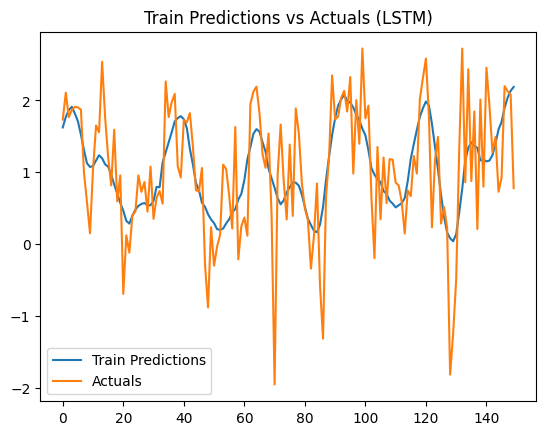

In [33]:
plt.plot(train_results['Train Predictions'][:150])
plt.plot(train_results['Actuals'][:150])

plt.title('Train Predictions vs Actuals (LSTM)')
plt.legend(['Train Predictions', 'Actuals'])
plt.show()

In [34]:
test_predictions = model2.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


,Test Predictions,Actuals
0,-0.169225,-0.630026
1,-0.264615,-0.558260
2,-0.360303,0.665232
3,-0.446561,0.240866
4,-0.560569,-0.637923
...,...,...
198,-0.566168,-1.117204
199,-0.605013,-1.339841
200,-0.634384,-1.618469
201,-0.644054,-0.629214


In [35]:
# resultados test R2, RMSE y MSE
R2_RMSE(test_results['Actuals'], test_results['Test Predictions'], std_y, mean_y)

R2: -0.34183086726882084
RMSE: 14208.00673338638
MSE: 201867455.33595276


(None, None, None)

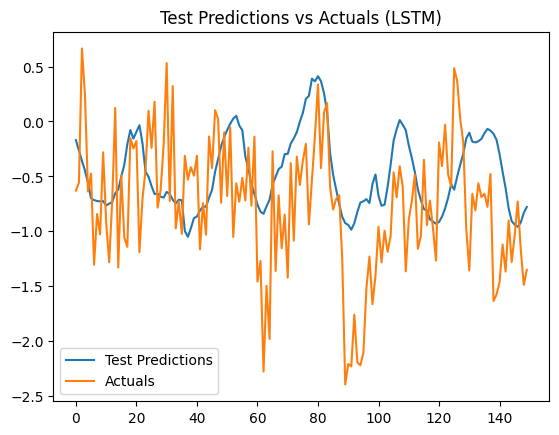

In [36]:
plt.plot(test_results['Test Predictions'][:150])
plt.plot(test_results['Actuals'][:150])

plt.title('Test Predictions vs Actuals (LSTM)')
plt.legend(['Test Predictions', 'Actuals'])
plt.show()

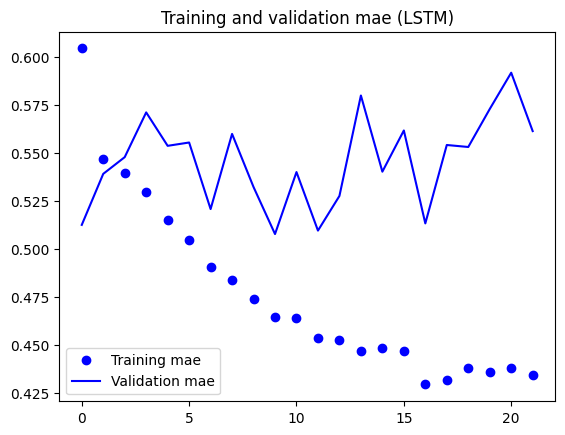

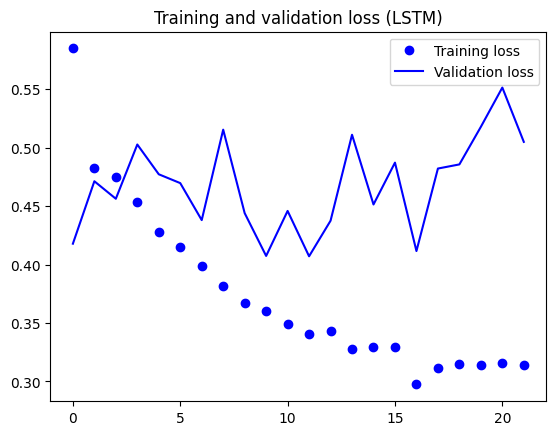

In [37]:
mae = history2.history['mae']
val_mae = history2.history['val_mae']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae (LSTM)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (LSTM)')
plt.legend()

plt.show()

### _3.3 GRU_

In [38]:
# generalización del modelo
model3 = Sequential()
model3.add(GRU(128, input_shape=(window_size, X.shape[2]), return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
model3.add(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model3.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(1, activation='linear'))  

# introducimos callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model3.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])  
history3 = model3.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50


/Users/ediazl/Documents/py_venv/venv-metal/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 630ms/step - loss: 0.6806 - mae: 0.6537 - val_loss: 0.4270 - val_mae: 0.5261 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 613ms/step - loss: 0.5388 - mae: 0.5860 - val_loss: 0.4258 - val_mae: 0.5261 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 729ms/step - loss: 0.5038 - mae: 0.5555 - val_loss: 0.4877 - val_mae: 0.5667 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 761ms/step - loss: 0.4844 - mae: 0.5456 - val_loss: 0.4292 - val_mae: 0.5261 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 29s 770ms/step - loss: 0.4523 - mae: 0.5323 - val_loss: 0.3890 - val_mae: 0.4957 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 781ms/step - loss: 0.4564 - mae: 0.5244 - val_loss: 0.3434 - val_mae: 0.4629 - learning_rate: 0.0010
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 720ms/step - loss: 0.4099 - mae: 0.5003 - val_loss: 0.3609 - val_mae: 0.4726 - learning_rate: 0.0010
Epoch 8/50

In [39]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 14, 128)        │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 14, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433,349 (1.65 MB)

 Trainable params: 144,449 (564.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 288,900 (1.10 MB)

In [40]:
train_predictions = model3.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step


,Train Predictions,Actuals
0,1.115423,1.732895
1,1.135921,2.108078
2,1.158485,1.767419
3,1.283502,1.866855
4,1.389454,1.910518
...,...,...
1195,-1.018668,-1.073597
1196,-1.144251,-1.011739
1197,-1.169911,-0.958293
1198,-1.103562,-1.037339


In [41]:
# resultados train R2, RMSE y MSE
R2_RMSE(train_results['Actuals'], train_results['Train Predictions'], std_y, mean_y)

R2: 0.6453674737473424
RMSE: 11644.708199466035
MSE: 135599229.0507115


(None, None, None)

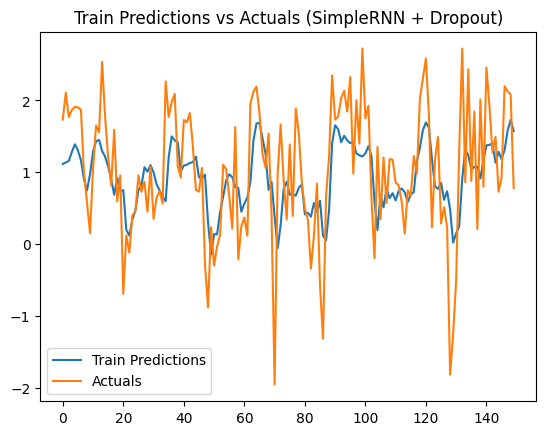

In [42]:
plt.plot(train_results['Train Predictions'][:150])
plt.plot(train_results['Actuals'][:150])

plt.title('Train Predictions vs Actuals (SimpleRNN + Dropout)')
plt.legend(['Train Predictions', 'Actuals'])
plt.show()

In [43]:
test_predictions = model3.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


,Test Predictions,Actuals
0,-0.309695,-0.630026
1,-0.424356,-0.558260
2,-0.500659,0.665232
3,-0.391999,0.240866
4,-0.321863,-0.637923
...,...,...
198,-0.186579,-1.117204
199,-0.199674,-1.339841
200,-0.316294,-1.618469
201,-0.386672,-0.629214


In [44]:
# resultados test R2, RMSE y MSE
R2_RMSE(test_results['Actuals'], test_results['Test Predictions'], std_y, mean_y)

R2: -0.3441729972801397
RMSE: 14220.401175716339
MSE: 202219809.59831464


(None, None, None)

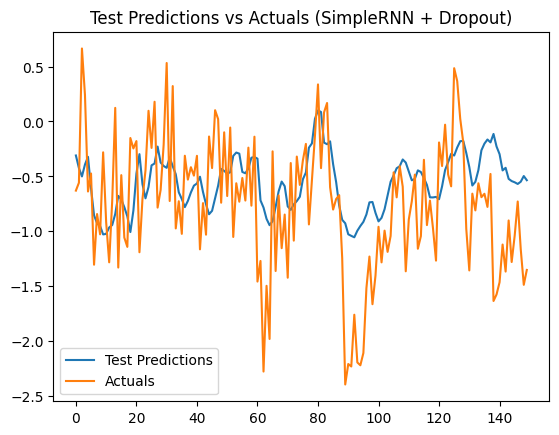

In [45]:
plt.plot(test_results['Test Predictions'][:150])
plt.plot(test_results['Actuals'][:150])

plt.title('Test Predictions vs Actuals (SimpleRNN + Dropout)')
plt.legend(['Test Predictions', 'Actuals'])
plt.show()

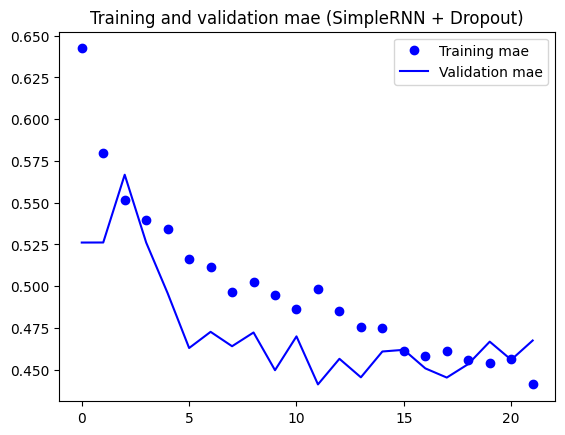

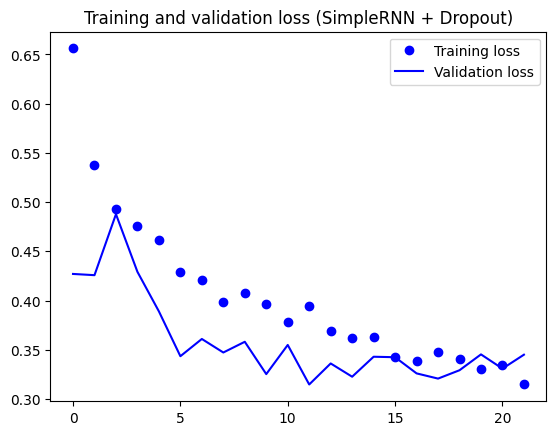

In [46]:
mae = history3.history['mae']
val_mae = history3.history['val_mae']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(mae))

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae (SimpleRNN + Dropout)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (SimpleRNN + Dropout)')
plt.legend()

plt.show()